In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [2]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [3]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [4]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


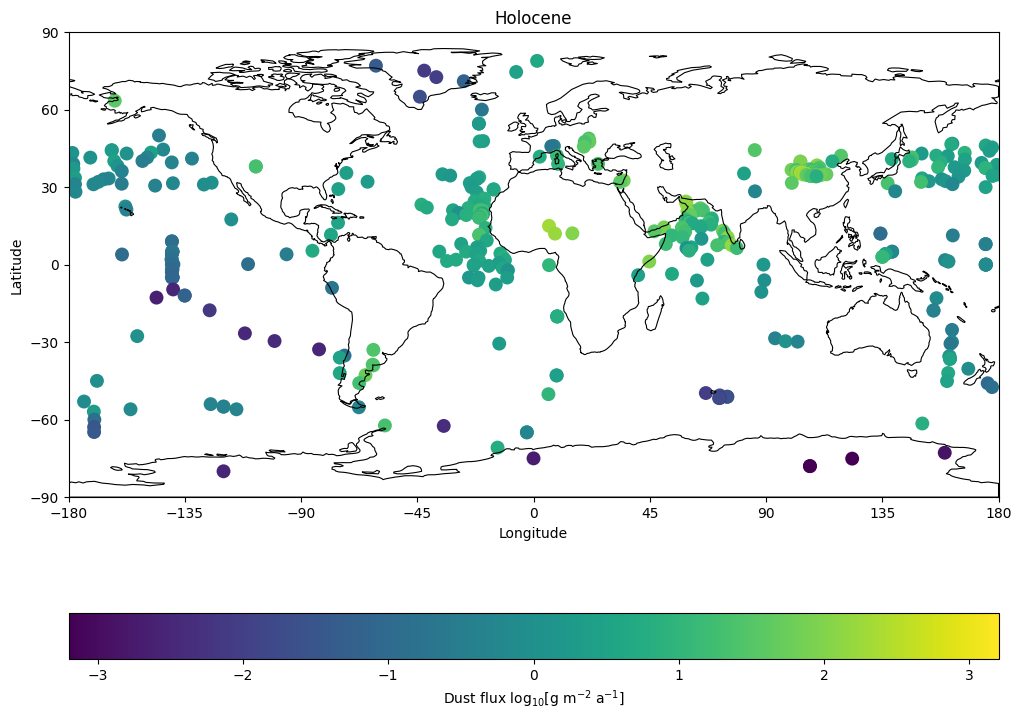

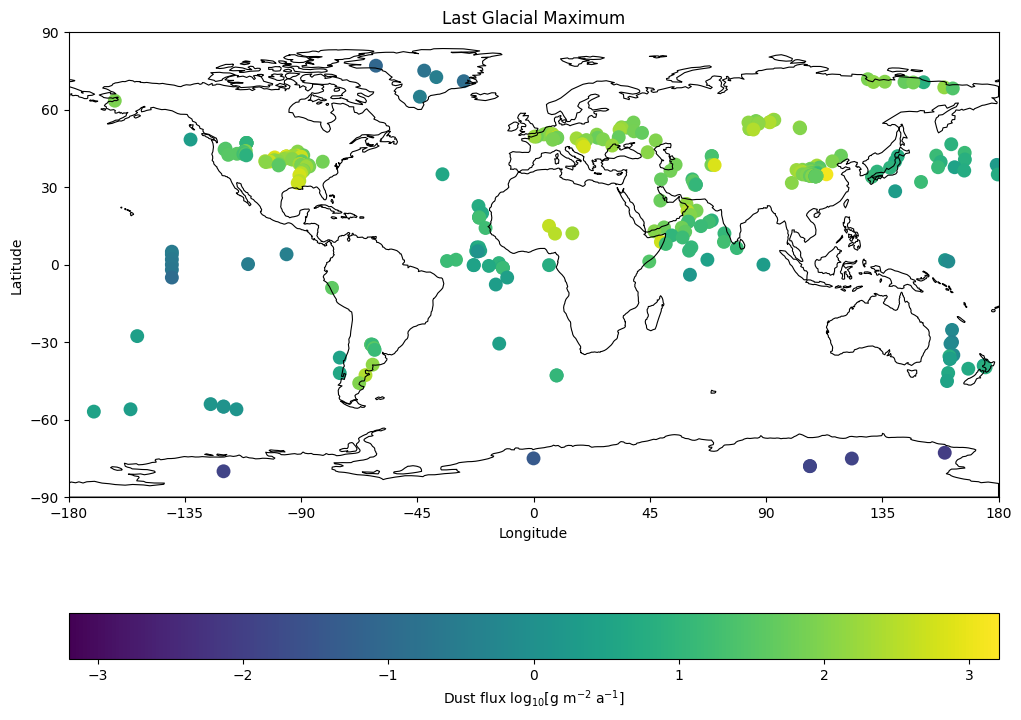

In [5]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [6]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

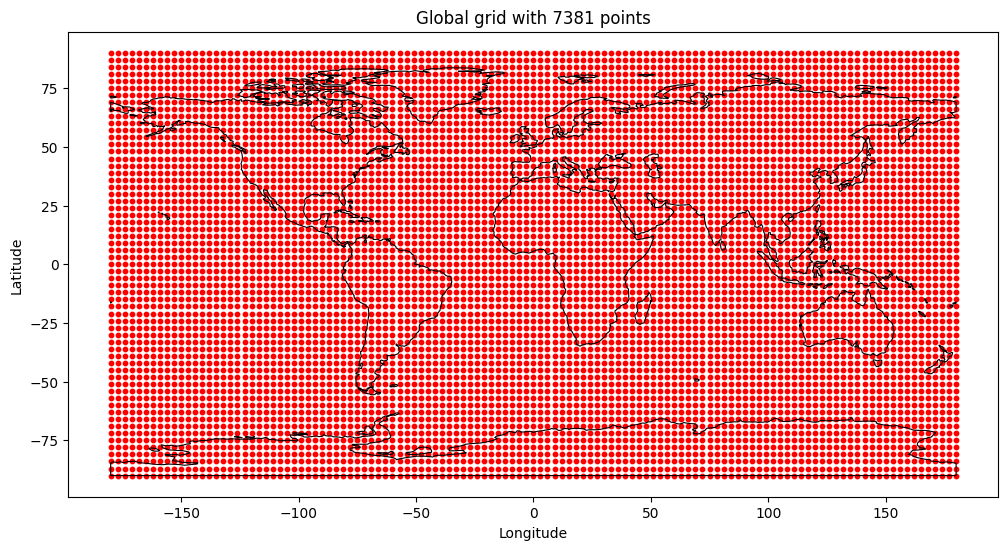

In [7]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [8]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

# Funcion de distancia geodesica

In [21]:
def distance_geodesic(x, y):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    x_lat_rad = np.radians(x[1])
    y_lat_rad = np.radians(y[1])
    x_lon_rad = np.radians(x[0])    
    y_lon_rad = np.radians(y[0])
    
    distance = 6371 * np.arccos(np.sin(x_lat_rad)*np.sin(y_lat_rad) + np.cos(x_lat_rad)*np.cos(y_lat_rad)*np.cos(x_lon_rad-y_lon_rad))
    
    return distance

In [10]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """
    
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

In [11]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

In [12]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm

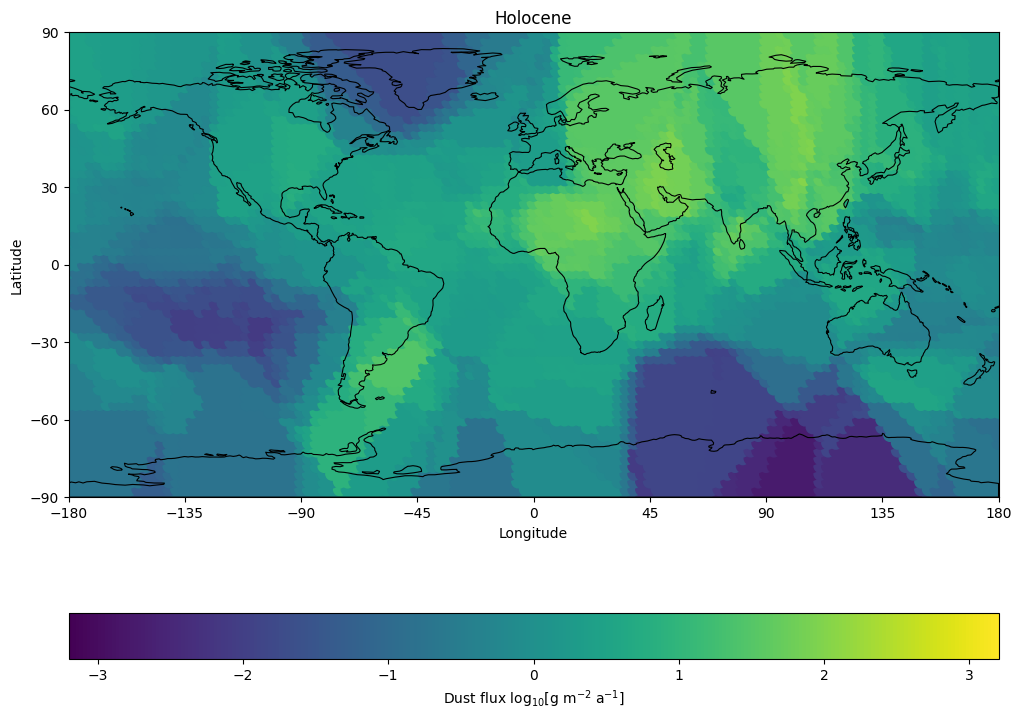

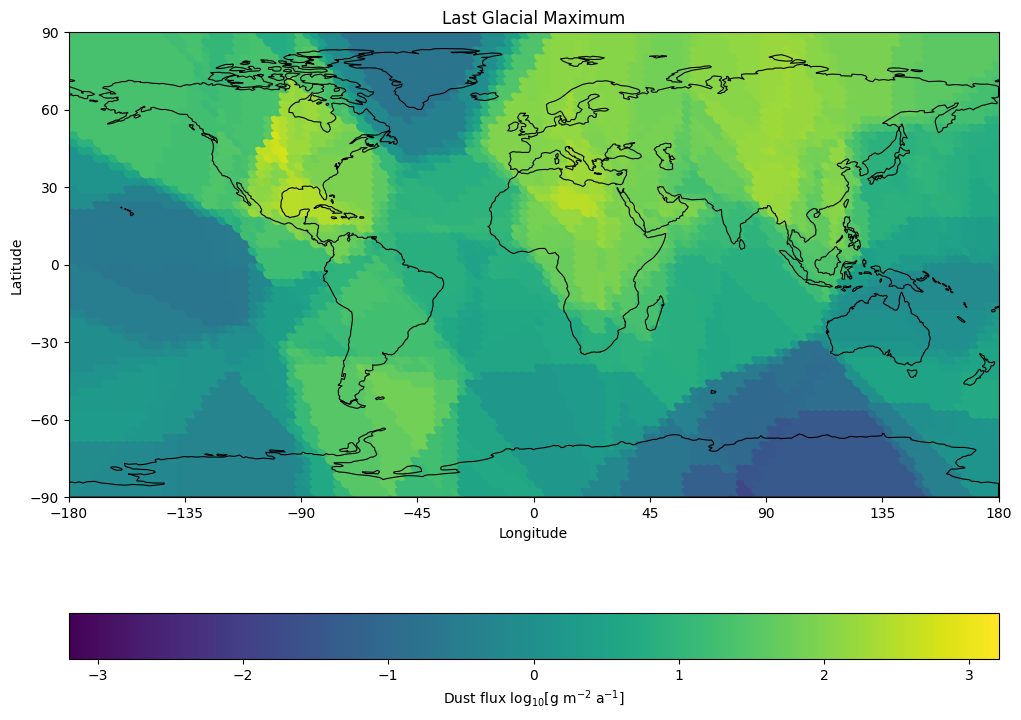

In [13]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

# Graficos geodesicos

In [22]:
estimations_holocene_geodesic = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_geodesic = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_geodesic[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm_geodesic[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol_geodesic"] = estimations_holocene_geodesic
df_global_grid["est_lgm_geodesic"] = estimations_lgm_geodesic

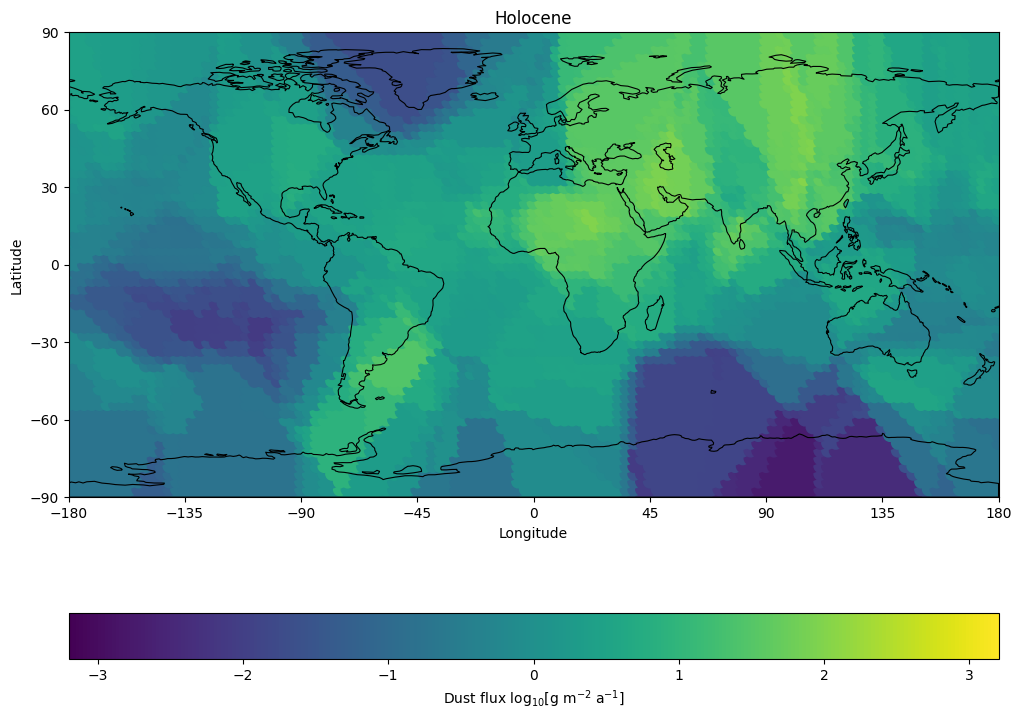

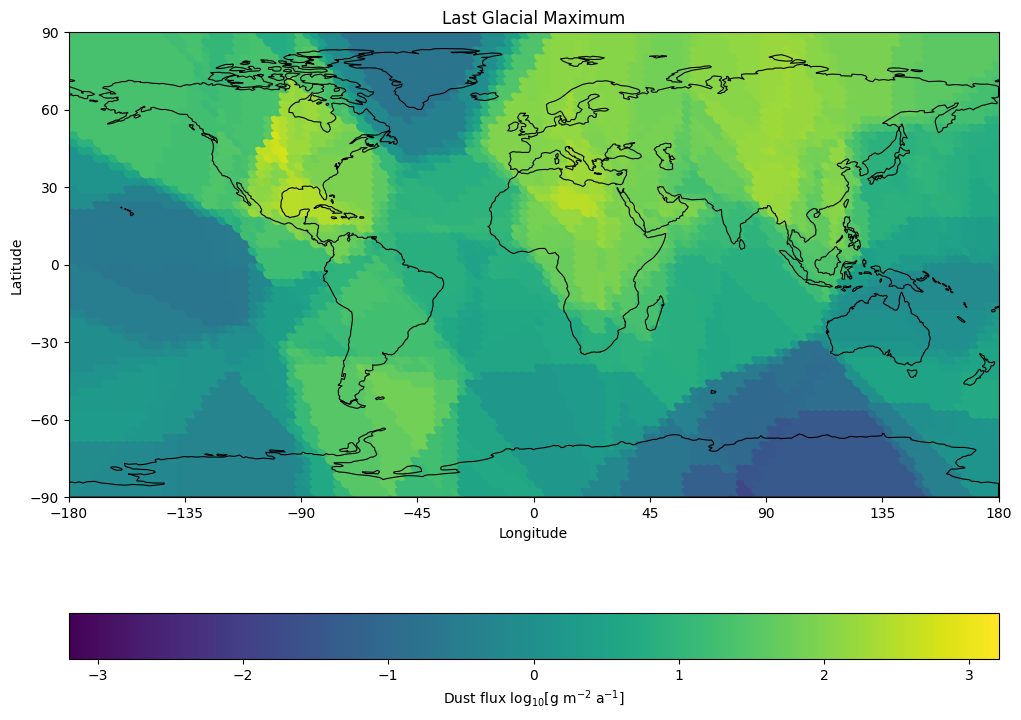

In [23]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE_GEODESIC',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM_GEODESIC',
                         label_str='est_lgm')

In [26]:
df_global_grid["lgm_diff"] = np.sqrt((df_global_grid["est_lgm_geodesic"] - df_global_grid["est_lgm"])**2)
df_global_grid["hol_diff"] = np.sqrt((df_global_grid["est_hol_geodesic"] - df_global_grid["est_hol"])**2)

In [27]:
df_global_grid

,lon,lat,est_hol,est_lgm,est_hol_geodesic,est_lgm_geodesic,lgm_diff,hol_diff
0,-180.0,-90.0,-0.736623,-0.111441,-3.034526,-1.804872,1.693431,2.297903
1,-177.0,-90.0,-0.736623,-0.111441,-3.034526,-1.804872,1.693431,2.297903
2,-174.0,-90.0,-0.736623,-0.175193,-3.034526,-1.804872,1.629679,2.297903
3,-171.0,-90.0,-0.736623,-0.175193,-3.034526,-1.804872,1.629679,2.297903
4,-168.0,-90.0,-0.740268,-0.175193,-3.034526,-1.804872,1.629679,2.294258
...,...,...,...,...,...,...,...,...
7376,168.0,90.0,0.388114,1.583464,-0.889438,-0.272050,1.855513,1.277551
7377,171.0,90.0,0.388114,1.583464,-0.889438,-0.272050,1.855513,1.277551
7378,174.0,90.0,0.388114,1.583464,-0.889438,-0.272050,1.855513,1.277551
7379,177.0,90.0,0.388114,1.583464,-0.889438,-0.272050,1.855513,1.277551


# Visualización de la diferencia

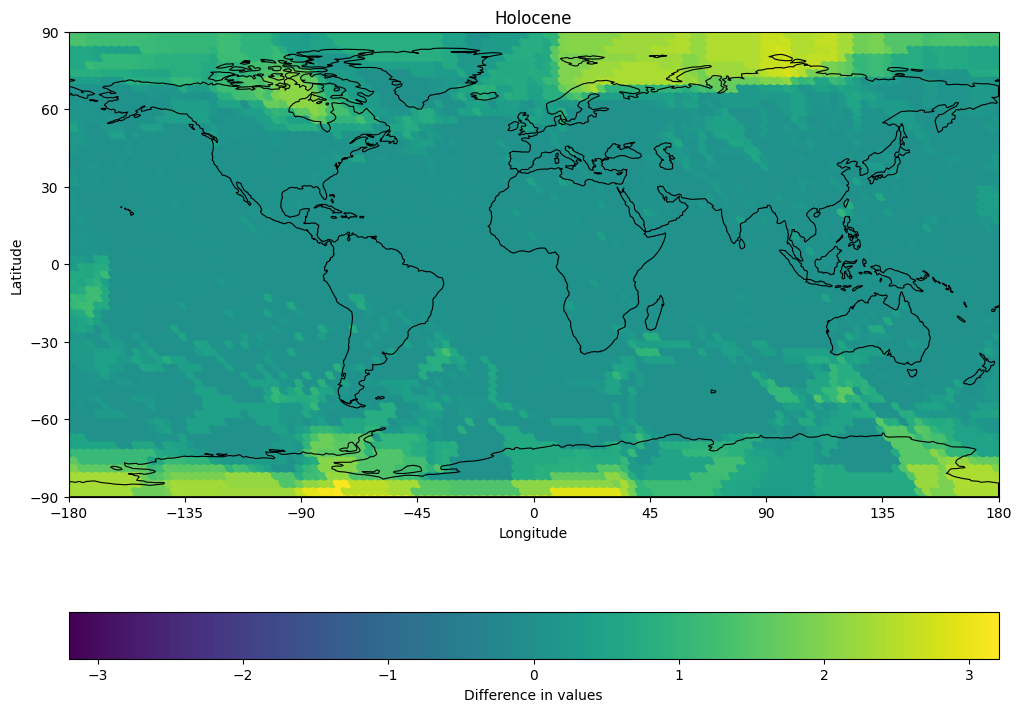

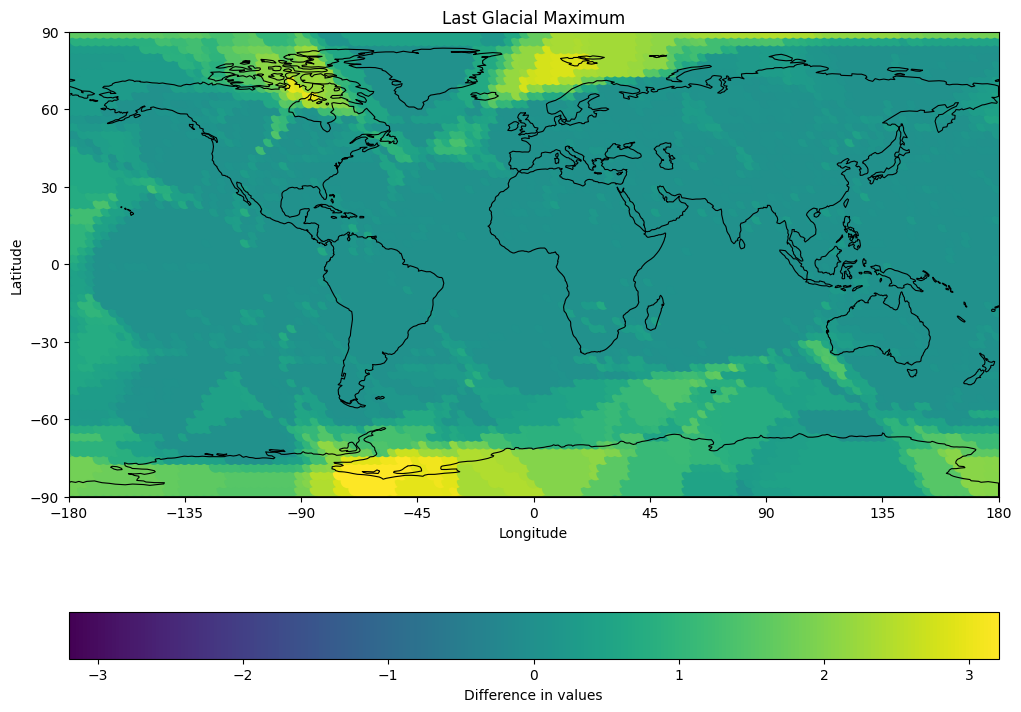

In [28]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE_DIFFERENCE',
                         label_str='hol_diff',
                        measure_units = "Difference in values")

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM_DIFFERENCE',
                         label_str='lgm_diff',
                        measure_units= "Difference in values")

# Preguntas

## a) ¿Por qué las diferencias son más grandes en una parte que otra parte del mundo?


Por que, el modelo euclidiano asume que la tierra es plana y que el trayecto más corto entre dos puntos es una linea recta, mientras que el modelo geodesico asume que la tierra es una esfera, que es más cercano a la realidad. Sin embargo, en la realidad la tierra no es una esfera perfecta si no una esfera achatada, lo que causa que cerca de los polos la tierra si actue más o menos como algo plano

## b) ¿Cuál método es más fidedigno en los polos sur y norte?

El modelo geodesico siempre debería ser el más fidedigno debido a que la tierra es más cercana a una esfera que a un disco, sin embargo, es posible que en los polos el modelo euclidiano sea más fidedigno debido a que estan "achatados" en relación al resto del planeta.

## c) ¿Cuál método es más fidedigno en longitud 180◦ ?

El modelo geodesico ya que la tierra es más cercana a una esfera que a un disco.

## d) ¿Cuáles son las diferencias entre los resultados para el Holoceno y el LGM?


El lgm parece mostrar un influjo de polvo muchisimo mayor. en relacion a las diferencias entre euclidiano y geodesico, el holoceno parece mostrar mayores diferencias en el hemisferio norte, mientras que el LGM parece mostrar mayores diferencias en el polo sur.

## e) ¿Cómo elegir el número de vecinos cercanos?

Podemos visualizar los resultados para distintos numeros de vecinos, pero esto es dificil si no sabemos exactamente que estamos buscando. En este caso particular creo que para elegir el numero de vecinos deberiamos tomar en cuenta en número de "puntos" en el global grid y ver con cuantos otros puntos de grid tienen contacto inmediato.